First, let's import necessary modules and libraries: 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Now let's load our working dataset, `Lung Cancer`: 

In [2]:
data = pd.read_csv("Datasets/survey lung cancer.csv")
data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


The _baseline human performance_ for **Lung Cancer** detection is:
- For $Accuracy$:
  - At least **70%-80%** using _chest X-ray images_.
  - Above **85%** using _CT scans_.
- For Area Under Curve $ROC$:  
  - A value above **0.90**.  

In [75]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,309.0,62.673139,8.210301,21.0,57.0,62.0,69.0,87.0
SMOKING,309.0,1.563107,0.496806,1.0,1.0,2.0,2.0,2.0
YELLOW_FINGERS,309.0,1.569579,0.495938,1.0,1.0,2.0,2.0,2.0
ANXIETY,309.0,1.498382,0.500808,1.0,1.0,1.0,2.0,2.0
PEER_PRESSURE,309.0,1.501618,0.500808,1.0,1.0,2.0,2.0,2.0
CHRONIC DISEASE,309.0,1.504854,0.500787,1.0,1.0,2.0,2.0,2.0
FATIGUE,309.0,1.673139,0.469827,1.0,1.0,2.0,2.0,2.0
ALLERGY,309.0,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0
WHEEZING,309.0,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0
ALCOHOL CONSUMING,309.0,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

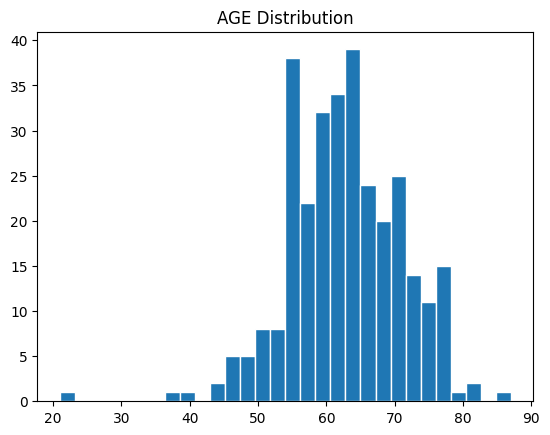

In [77]:
plt.hist(data["AGE"], bins=30, edgecolor="white")
plt.title("AGE Distribution")
plt.show()     

In [78]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

encoder = LabelEncoder()
scaler = MinMaxScaler(feature_range=(1, 2))

data["GENDER"] = encoder.fit_transform(data["GENDER"])
data["LUNG_CANCER"] = encoder.fit_transform(data["LUNG_CANCER"])

data["AGE"] = scaler.fit_transform(df[["AGE"]])

data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,1.727273,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,1.803030,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,1.575758,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,1.636364,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,1.636364,1,2,1,1,1,1,1,2,1,2,2,1,1,0


In [83]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=data["LUNG_CANCER"], random_state=40)

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9032258064516129

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.91      0.98      0.95        54

    accuracy                           0.90        62
   macro avg       0.83      0.68      0.72        62
weighted avg       0.89      0.90      0.89        62


Confusion Matrix:
 [[ 3  5]
 [ 1 53]]


In [72]:
data["LUNG_CANCER"].value_counts()

LUNG_CANCER
1    270
0     39
Name: count, dtype: int64

In [4]:
data = pd.read_csv("Datasets/TCGA-PANCAN-HiSeq-801x20531/data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gene_0,801.0,0.026642,0.136850,0.000000,0.000000,0.000000,0.000000,1.482332
gene_1,801.0,3.010909,1.200828,0.000000,2.299039,3.143687,3.883484,6.237034
gene_2,801.0,3.095350,1.065601,0.000000,2.390365,3.127006,3.802534,6.063484
gene_3,801.0,6.722305,0.638819,5.009284,6.303346,6.655893,7.038447,10.129528
gene_4,801.0,9.813612,0.506537,8.435999,9.464466,9.791599,10.142324,11.355621
...,...,...,...,...,...,...,...,...
gene_20526,801.0,11.742228,0.670371,9.045255,11.315857,11.749802,12.177852,13.715361
gene_20527,801.0,10.155271,0.580569,7.530141,9.836525,10.191207,10.578561,11.675653
gene_20528,801.0,9.590726,0.563849,7.864533,9.244219,9.566511,9.917888,12.813320
gene_20529,801.0,5.528177,2.073859,0.593975,4.092385,5.218618,6.876382,11.205836


In [8]:
data.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [20]:
data.max()

Unnamed: 0    sample_99
gene_0         1.482332
gene_1         6.237034
gene_2         6.063484
gene_3        10.129528
                ...    
gene_20526    13.715361
gene_20527    11.675653
gene_20528     12.81332
gene_20529    11.205836
gene_20530     5.254133
Length: 20532, dtype: object

In [2]:
from sklearn.datasets import load_breast_cancer 

breast_cancer = load_breast_cancer() 
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names) 
df['target'] = breast_cancer.target
df.corr()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,-0.730029
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,-0.415185
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,-0.742636
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,-0.708984
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,-0.358560
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,-0.596534
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,-0.696360
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,-0.330499
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,0.012838


In [4]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['target'])
y = df['target']

scaler = StandardScaler()
normalized_array = scaler.fit_transform(X)
normalized_X = pd.DataFrame(normalized_array, columns=X.columns)


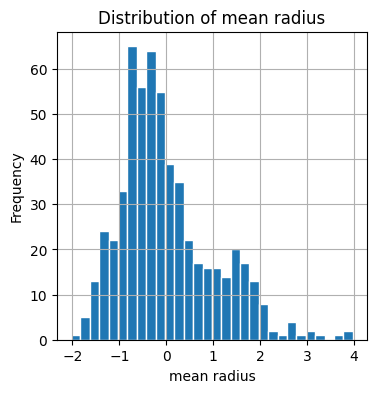

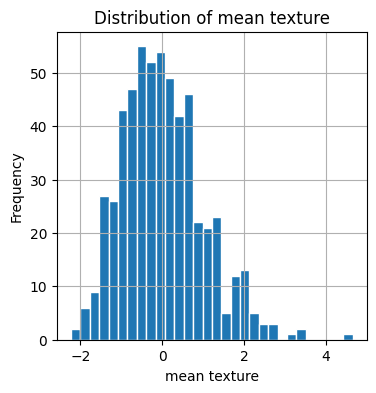

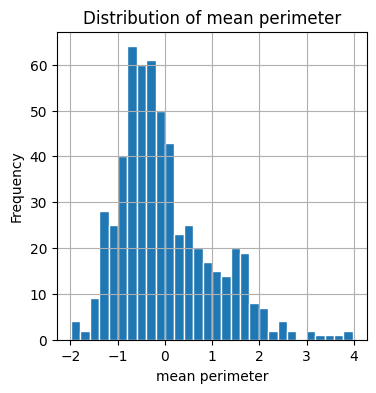

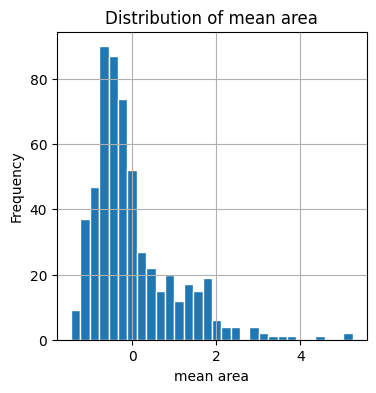

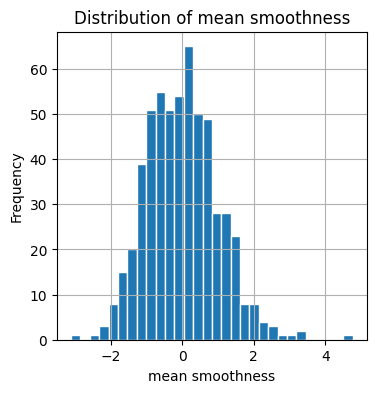

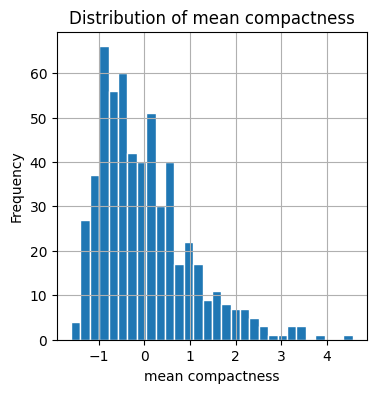

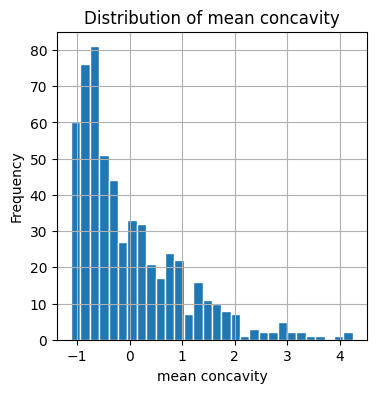

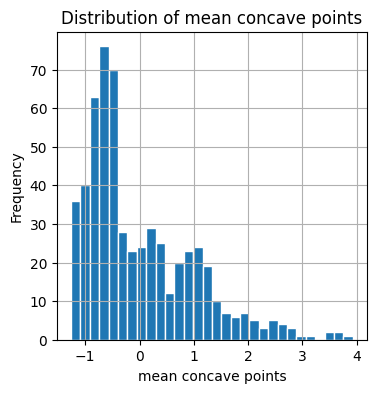

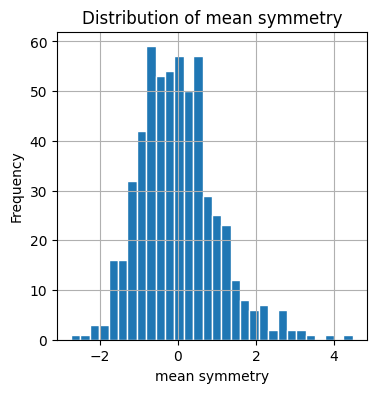

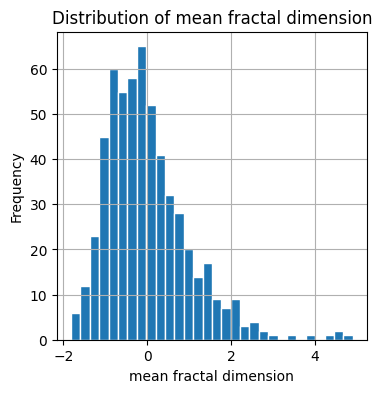

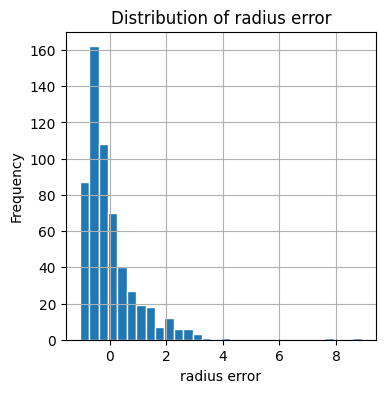

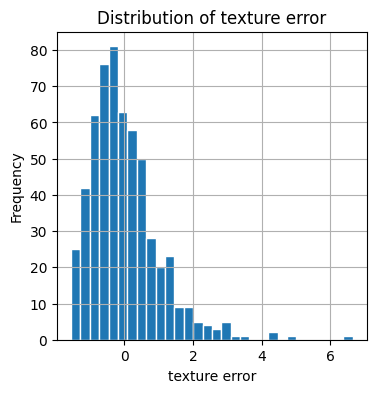

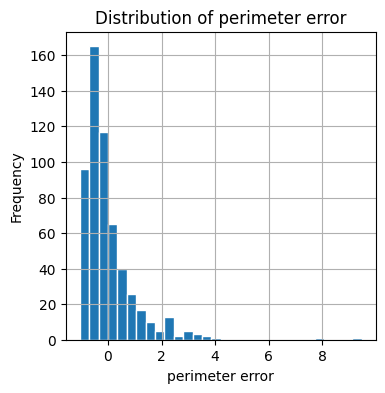

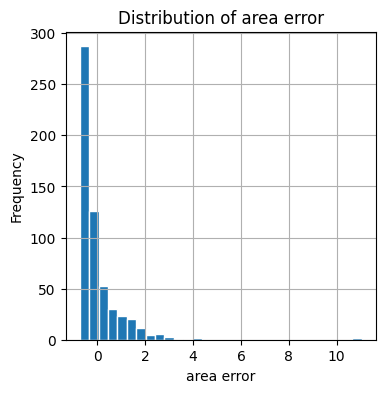

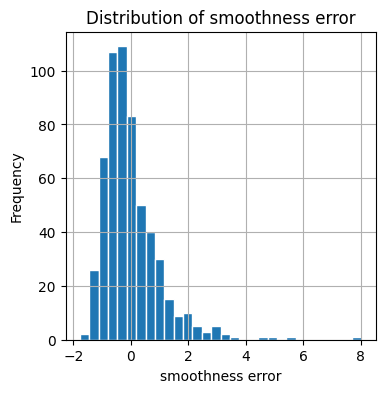

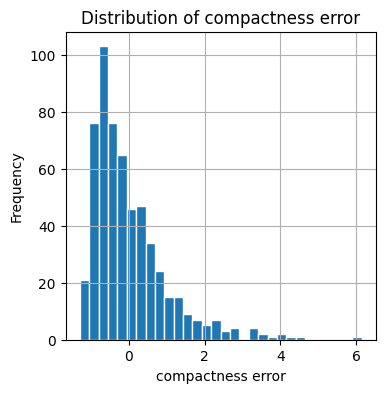

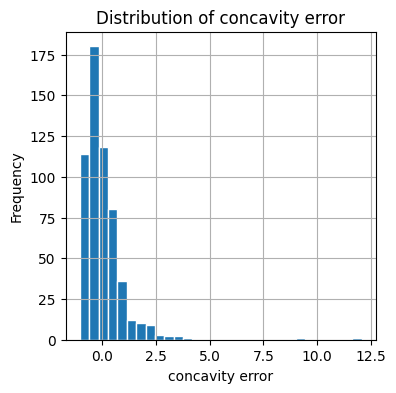

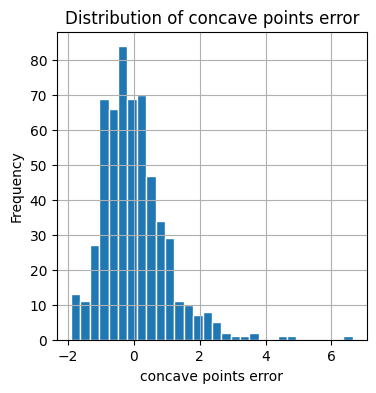

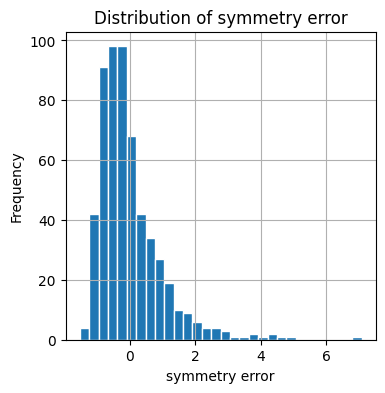

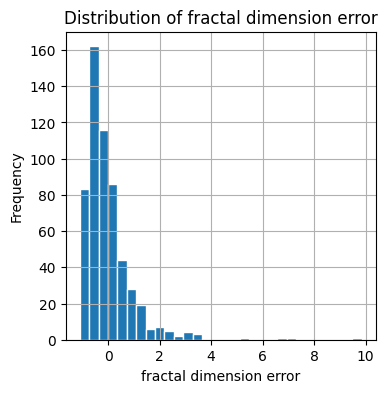

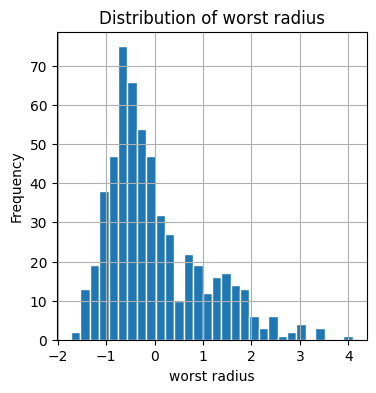

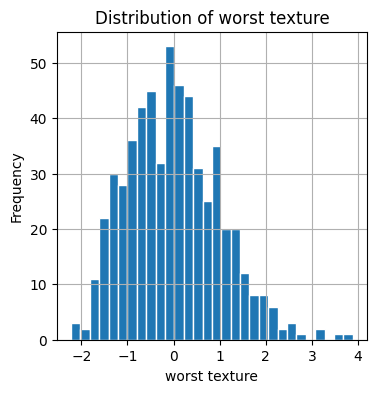

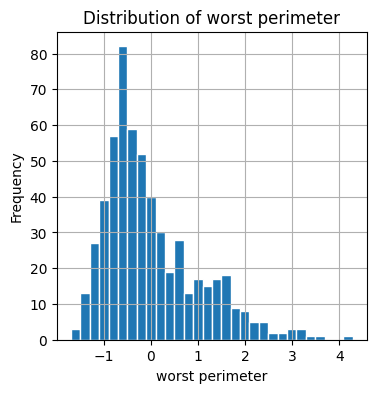

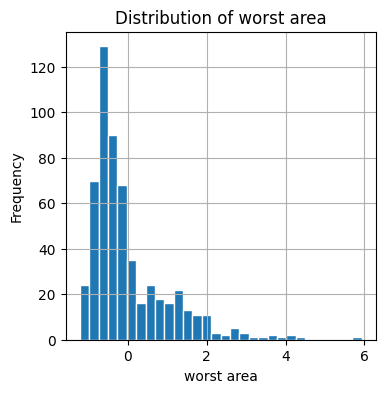

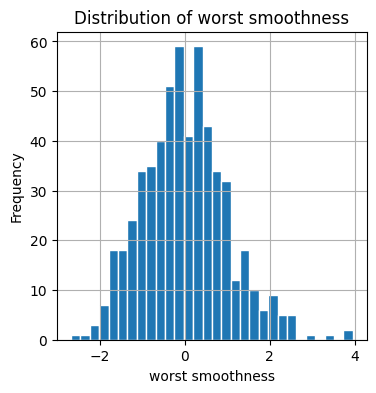

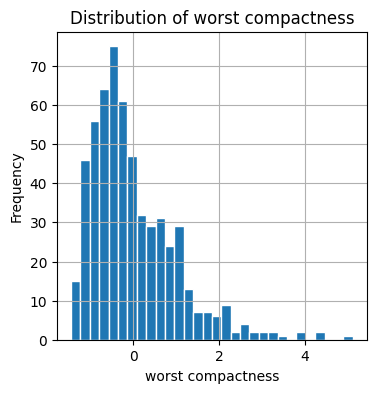

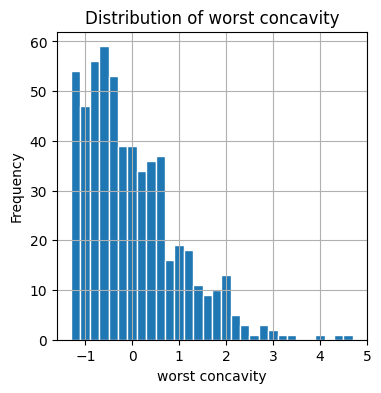

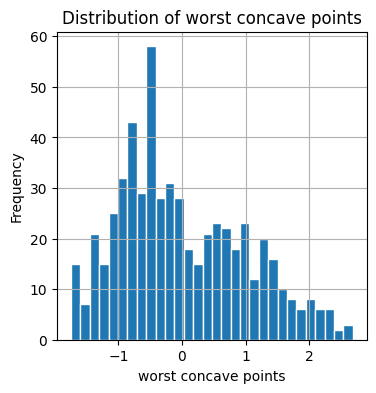

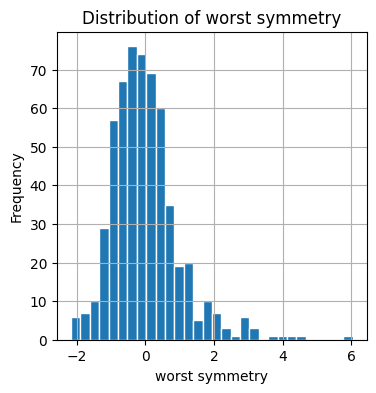

In [9]:
for column in normalized_X.columns[:-1]:
    plt.figure(figsize=(4, 4))
    plt.hist(normalized_X[column], bins=30, edgecolor='white')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
parameter = {'n_estimators':[10, 50, 100, 200],
             'max_depth':[None, 10, 20, 30, 40],
             'min_samples_split':[2, 5, 10],
             'min_samples_leaf':[1, 2, 4],
             'bootstrap':[True, False]}

In [6]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=42)

grid = GridSearchCV(estimator=rf, param_grid=parameter, cv=5, verbose=2, n_jobs=1)
grid.fit(X_train,y_train)
best_grid=grid.best_estimator_
ypred_grid=best_grid.predict(X_test)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=

In [7]:
from sklearn.metrics import accuracy_score , classification_report

print("best parameters found by grid search:", grid.best_params_)
print("grid search accuracy :", accuracy_score(y_test,ypred_grid))
print("\ngrid search classification report :\n", classification_report(y_test,ypred_grid))

best parameters found by grid search: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
grid search accuracy : 0.9649122807017544

grid search classification report :
               precision    recall  f1-score   support

           0       0.93      0.97      0.95        39
           1       0.99      0.96      0.97        75

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

